In [38]:
import torch
import torch.nn as nn
import torchsummary
import torchmetrics
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from h5 import *

import time
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [8]:
from triqs.operators import *
from triqs.gf import *
from triqs.gf.descriptors import MatsubaraToLegendre

In [145]:
def load_db(filename):
    n_entries = 0
    params = 0
    smpls_list = 0
    with HDFArchive(filename, 'r') as ar:
        n_entries = ar['n_entries']
        params = ar["params"] 
        smpls_list = ar["samples"] 
    # print(params)
    data2train = [ [[params[smpl_id]['U'], params[smpl_id]['beta'], np.real(sample['G0_legendre'].data).flatten()], 
                    [ np.real(sample['G_legendre'].data).flatten()]]  
                  for smpl_id, sample in enumerate(smpls_list)] 
    return data2train

db_names = [
    'database_v4.h5',
    'database_v5.h5',
    'database_v6.h5'
            ]
data_list = [load_db(db_name) for db_name in db_names]
data = []
for dataq in data_list:
    data.extend(dataq)
print(len(data))

1500


In [146]:
data[0]

[[4.0378463867341114,
  17.605738854924656,
  array([-1.89072291e+00, -1.11585952e+00, -1.60697188e+00, -1.49140586e-01,
         -5.94216251e-01,  6.09605065e-02, -2.40239615e-01,  2.91876348e-02,
         -1.00406936e-01,  3.42558746e-03, -3.72658735e-02, -2.49308569e-03,
         -1.20260415e-02, -1.89845357e-03, -3.43098440e-03, -8.02484327e-04,
         -8.80172479e-04, -2.58280615e-04, -2.05986216e-04, -6.91736363e-05,
         -4.51914963e-05, -1.62255511e-05, -1.05391112e-05, -3.69830586e-06,
         -4.04619627e-06, -1.19643679e-06, -3.32022488e-06, -8.48034087e-07,
         -3.71313899e-06, -9.15451717e-07, -4.34961740e-06, -1.06496497e-06,
         -5.08174120e-06, -1.24041115e-06, -5.88847427e-06, -1.43374658e-06,
         -6.76871866e-06, -1.64430600e-06, -7.72415789e-06, -1.87242365e-06])],
 [array([-2.13319902e+00,  1.55892636e-01, -1.03226874e+00,  3.61647653e-01,
         -5.53901206e-01,  2.34037955e-01, -3.12472519e-01,  1.45225218e-01,
         -1.87161380e-01,  9.

In [151]:
def make_training_Data(db):
    X = np.array([np.hstack(sample[0]) for sample in db])
    Y = np.array([sample[1][0] for sample in db])
    return X, Y

features, targets = make_training_Data(data)
print(f'in total {len(features)} rows')
print(f'num features {len(features[0])}')
print(f'num targets {len(targets[0])}')

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

print(f'num train {len(X_train)}')
print(f'num test {len(X_test)}')


in total 1500 rows
num features 42
num targets 30
num train 1200
num test 300


In [34]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_size=42, output_size=30):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            # Your network structure comes here
            nn.Linear(input_size, 64),  # First hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(64, 128),           # Second hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(128, 64),           # Third hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(64, output_size)    # Output layer
        )    
        #     nn.Linear(784, 32),
        #     nn.BatchNorm1d(32),
        #     nn.ELU(),
        #     nn.Linear(32,10),
        #     nn.Linear(input_shape, num_classes)
        # )
        
    def forward(self, inp):       
        out = self.model(inp)
        # print(out)
        return out
    
torchsummary.summary(TinyNeuralNetwork().to(device), (500, 42))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 500, 64]           2,752
              ReLU-2              [-1, 500, 64]               0
            Linear-3             [-1, 500, 128]           8,320
              ReLU-4             [-1, 500, 128]               0
            Linear-5              [-1, 500, 64]           8,256
              ReLU-6              [-1, 500, 64]               0
            Linear-7              [-1, 500, 30]           1,950
Total params: 21,278
Trainable params: 21,278
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 2.07
Params size (MB): 0.08
Estimated Total Size (MB): 2.23
----------------------------------------------------------------


In [161]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield torch.Tensor(X[batch_idx]), torch.Tensor(Y[batch_idx])


# batch_size = 4
# train_loader = get_batches((X_train, y_train), batch_size)
# test_loader = get_batches((X_test, y_test), batch_size)

batch_size = 128
for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
    print(x_batch.shape)
    

torch.Size([128, 42])
torch.Size([128, 42])
torch.Size([128, 42])
torch.Size([128, 42])
torch.Size([128, 42])
torch.Size([128, 42])
torch.Size([128, 42])
torch.Size([128, 42])
torch.Size([128, 42])
torch.Size([48, 42])


In [165]:
def train_model(model, batch_size, loss_func, opt, acc, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
            # print(X_batch.shape)
            
            X_batch = X_batch.to(device, torch.float32)
            y_batch = y_batch.to(device, torch.float32)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            
            # print(X_batch)
            y_pred = model(X_batch)
            # print(y_pred)
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            ep_train_loss.append(loss.item())

        
        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in get_batches((X_test, y_test), batch_size):
                # move data to target device
                
                X_batch = X_batch.to(device, torch.float32)
                y_batch = y_batch.to(device, torch.float32)
                # compute predictions
                
                y_pred = model(X_batch)
                ep_val_loss.append( loss_func(y_pred, y_batch) )
                ep_val_accuracy.append( acc(y_pred, y_batch))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [166]:
model = TinyNeuralNetwork().to(device, torch.float32)
opt =  torch.optim.Adam(model.parameters(), lr=1e-3) 
loss_func = nn.MSELoss()
acc = torchmetrics.MeanSquaredError()

In [167]:
n_epochs = 100
batch_size = 128
train_loss, test_loss, val_accuracy = train_model(model, batch_size, loss_func, opt, acc, n_epochs)

Epoch 1 of 100 took 0.024s
	  training loss: 0.095541
	validation loss: 0.047930
	validation accuracy: 0.048
Epoch 2 of 100 took 0.022s
	  training loss: 0.029040
	validation loss: 0.016608
	validation accuracy: 0.017
Epoch 3 of 100 took 0.020s
	  training loss: 0.016526
	validation loss: 0.014734
	validation accuracy: 0.015
Epoch 4 of 100 took 0.023s
	  training loss: 0.014148
	validation loss: 0.011660
	validation accuracy: 0.012
Epoch 5 of 100 took 0.022s
	  training loss: 0.011927
	validation loss: 0.010846
	validation accuracy: 0.011
Epoch 6 of 100 took 0.022s
	  training loss: 0.011029
	validation loss: 0.009793
	validation accuracy: 0.010
Epoch 7 of 100 took 0.021s
	  training loss: 0.009789
	validation loss: 0.008823
	validation accuracy: 0.009
Epoch 8 of 100 took 0.020s
	  training loss: 0.008573
	validation loss: 0.007431
	validation accuracy: 0.007
Epoch 9 of 100 took 0.017s
	  training loss: 0.007658
	validation loss: 0.006475
	validation accuracy: 0.006
Epoch 10 of 100 too

In [168]:
def plot_train_process(train_loss, test_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(test_loss, label='test')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

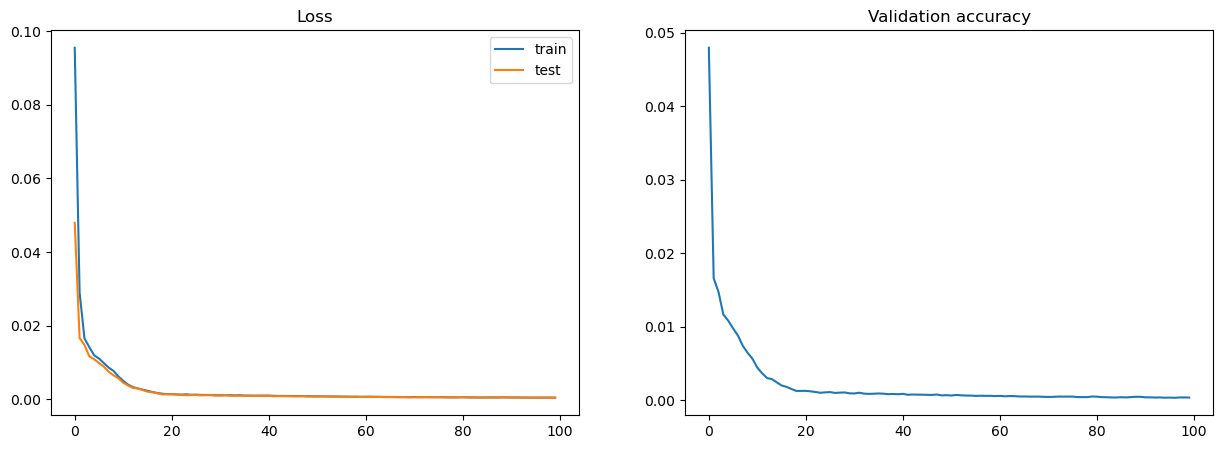

In [169]:
plot_train_process(train_loss, test_loss, val_accuracy)

In [170]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [174]:
save_checkpoint(checkpoint_path='./model_v1', model=model, optimizer=opt)

model saved to ./model_v1


In [175]:
load_checkpoint(checkpoint_path='./model_v1', model=model, optimizer=opt)

model loaded from ./model_v1
